Iterations ENKF <class 'model2_class.Model2'>: 100%|██████████| 396/396 [02:43<00:00,  2.42it/s]
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model1_class.py:242: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])
c:\Users\yoswald\Dropbox\Arbeit\postdoc_leeds\real_time_ineq_abm\rtabm\model2_class.py:192: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0%', '0%', '20%', '40%', '60%', '80%'])


this is total_wealth_ts [[ 419.76969375  420.69910519  421.71912877 ... 2024.27098517
  2030.43107436 2034.41351175]
 [ 265.23324554  265.43244007  265.98135337 ... 1713.70594889
  1718.73674269 1723.5538477 ]
 [ 472.67453861  473.1012195   474.26173891 ... 2208.48470515
  2213.6846093  2219.99219601]
 ...
 [ 674.72144247  676.41655361  677.9507755  ... 2729.45292718
  2735.22246382 2745.43220718]
 [ 278.59544943  279.8510103   280.50338288 ... 1624.7473078
  1630.80223036 1636.86962507]
 [1165.14687583 1166.38258082 1167.38865921 ... 4285.47723471
  4295.88009239 4303.6983068 ]]
this is total_wealth_ts [[1226.54430506 1229.37679707 1232.52556551 ... 3733.67046434
  3742.71188558 3750.37807757]
 [1252.57978193 1254.92031762 1258.46330345 ... 4071.95329939
  4080.44975113 4089.97193545]
 [2104.48801613 2109.36436914 2114.73940639 ... 5936.69379682
  5950.10407596 5963.13061372]
 ...
 [1597.10997084 1600.71891715 1604.39009094 ... 4783.65082863
  4792.61202383 4804.17486571]
 [1314.55557

C:\Users\yoswald\AppData\Local\Temp\ipykernel_32452\339789845.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
C:\Users\yoswald\AppData\Local\Temp\ipykernel_32452\339789845.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


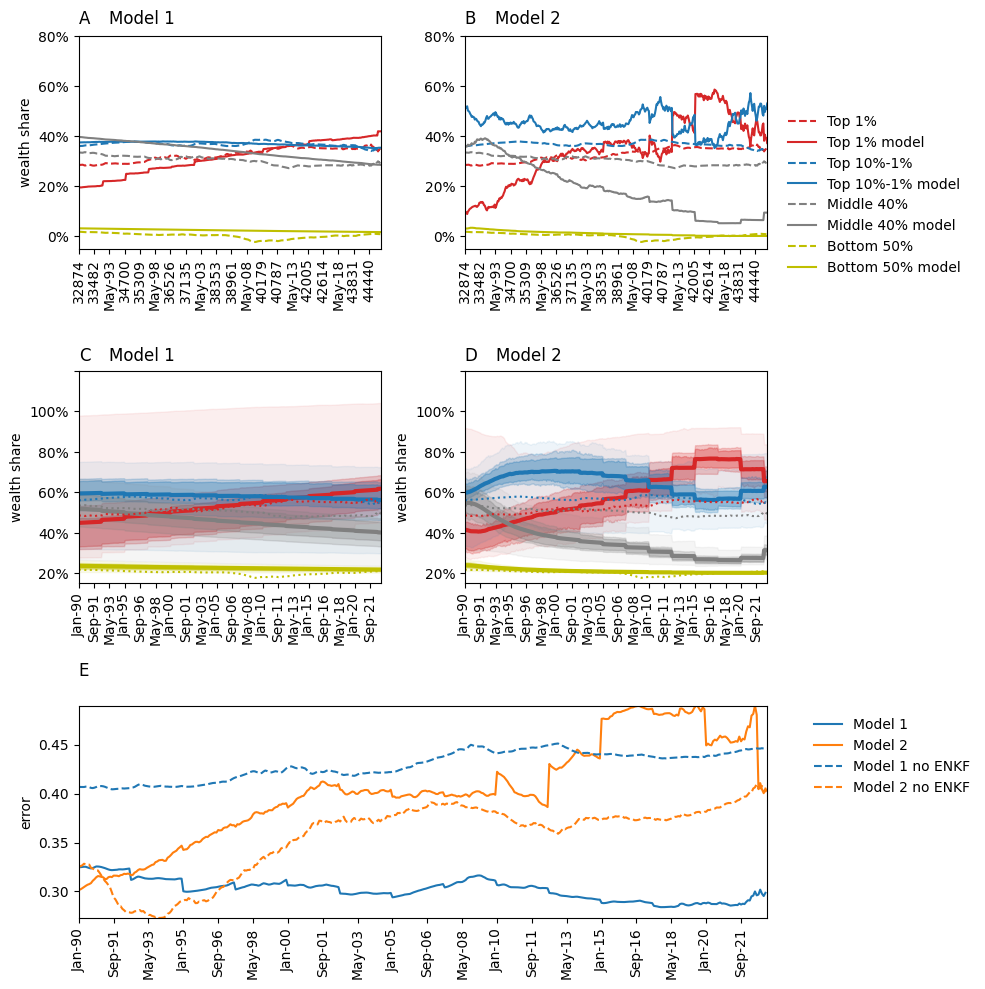

In [2]:
#General packages
import os
import numpy as np
from tqdm import tqdm  ### package for progress bars
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
### MODEL 1 infrastructure
import pandas as pd
from model1_class import Model1
from run_enkf import *
### MODEL 2 infrastructure
from model2_class import Model2
#from run_both_models_n_times_and_compute_error import *
import import_ipynb
tqdm.pandas()

#%%


class Experiment1:
    def __init__(self, num_agents, ensemble_size, macro_state_dim, start_year, end_year, filter_freq):
        self.num_agents = num_agents
        self.ensemble_size = ensemble_size
        self.macro_state_dim = macro_state_dim
        self.enkf1 = None
        self.enkf2 = None
        self.start_year = start_year
        self.end_year = end_year

    def run_both_enkf(self, filter_freq):
        
        model_params1 = {"population_size": self.num_agents,
                        "growth_rate": 0.025,
                        "b_begin": 1.3,
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "uncertainty_para": 0.1}
        
        model_params2 = {"population_size": self.num_agents, 
                        "concavity": 1,
                        "growth_rate": 0.025, 
                        "distribution": "exponential_pareto", # either "Pareto_lognormal" or "exponential_pareto"
                        "start_year": self.start_year,
                        "adaptive_sensitivity": 0.02,
                        "uncertainty_para": 0}

        
        self.enkf1 = prepare_enkf(Model1,
                                  model_params= model_params1,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        self.enkf2 = prepare_enkf(Model2,
                                   model_params= model_params2,
                                  ensemble_size = self.ensemble_size,
                                  macro_state_dim = self.macro_state_dim,
                                  filter_freq = filter_freq,
                                  uncertainty_obs = 0.5)
        
        run_enkf(self.enkf1, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)
        run_enkf(self.enkf2, start_year=self.start_year, end_year=self.end_year, filter_freq = filter_freq)

    def plot_results(self):

        fig = plt.figure(figsize=(10, 10))
        # Create a gridspec object
        gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])
        # Create individual subplots
        ax0 = plt.subplot(gs[0, 0])
        ax1 = plt.subplot(gs[0, 1])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[1, 1])
        ax4 = plt.subplot(gs[2, :])  # This one spans both columns

        
        self.enkf1.models[0].plot_wealth_groups_over_time(ax0, self.start_year, self.end_year)
        self.enkf2.models[0].plot_wealth_groups_over_time(ax1, self.start_year, self.end_year)
        self.enkf1.plot_fanchart(ax2)
        self.enkf2.plot_fanchart(ax3)        
        self.enkf1.plot_error(ax4)
        self.enkf2.plot_error(ax4)

        ###EXTRAS
        #AX0
        ax0.text(0, 0.85, 'A', fontsize = 12)
        ax0.text(40, 0.85, 'Model 1', fontsize = 12)
        #AX1
        ax1.legend(loc=(1.05, -0.15), frameon = False) ### legend only here
        ax1.text(0, 0.85, 'B', fontsize = 12)
        ax1.text(40, 0.85, 'Model 2', fontsize = 12)
        #AX2
        ax2.text(0, 1.05, 'C', fontsize = 12)
        ax2.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax2.text(40,1.05, 'Model 1', fontsize = 12)
        #AX3
        ax3.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax3.text(0,1.05, 'D', fontsize = 12)
        ax3.text(40,1.05, 'Model 2', fontsize = 12)

        path = '..'
        with open(os.path.join(path, 'data', 'mean_errors.csv')) as f:
            errors_df_no_enkf = pd.read_csv(f, encoding='unicode_escape')

        ax4.plot(errors_df_no_enkf['mean_error_model1'], linestyle='--', label='Model 1 no ENKF', color='tab:blue')
        ax4.plot(errors_df_no_enkf['mean_error_model2'], linestyle='--', label='Model 2 no ENKF', color='tab:orange')
        ax4.legend(bbox_to_anchor=(1.05, 1), frameon=False)
        
        # Get the limits
        x_min, x_max = ax4.get_xlim()
        y_min, y_max = ax4.get_ylim()
        ax4.text(0, y_max+0.02, 'E', fontsize = 12)
        ax4.margins(0)


        plt.tight_layout()
        plt.savefig('fig4.png', dpi=300)
        plt.show()
  
        
        
# Example usage
if __name__ == "__main__":
    filter_freq = 30
    experiment1 = Experiment1(num_agents=100, 
                              ensemble_size=100, 
                              macro_state_dim=4, 
                              start_year=1990,
                              end_year=2022,
                              filter_freq = filter_freq)
    experiment1.run_both_enkf(filter_freq = filter_freq)
    experiment1.plot_results()
    agent_states_model1 = experiment1.enkf1.micro_history
    agent_states_model2 = experiment1.enkf2.micro_history



In [3]:
# Initialize an empty list to store the data
data = []
# Iterate over each array in the micro_history
for time_step, array in enumerate(agent_states_model1):
    # Create a DataFrame from the array
    df = pd.DataFrame(array)
    
    # Add the time_step column
    df['time_step'] = time_step + 1
    
    print(df.head())
    # Append the DataFrame to the list
    data.append(df)

# Concatenate the list into a single DataFrame
result_df = pd.concat(data, ignore_index=True)

# Optionally, rename the columns to be more descriptive
result_df.columns = [f'ensemble_member_{i}' for i in range(result_df.shape[1] - 1)] + ['time_step']

print(result_df.head())


            0           1           2           3           4           5  \
0  465.204506  294.593929  509.693498  629.328688  683.601511  330.843807   
1  133.354879  232.330773  434.244287  129.860858  303.342022  156.094049   
2  123.001596  154.295421  336.874638   95.909540  196.032250   99.662323   
3  107.711777  139.446661  237.958196   82.821092  179.164019   93.698829   
4   95.936475  107.221181  195.442463   71.446436  143.701272   91.858221   

            6           7           8           9  ...           91  \
0  872.404064  517.002110  692.404363  151.589865  ...  2828.527525   
1  399.840034  378.501790  418.993752  133.936941  ...   375.293919   
2  178.847323  329.703296  124.879157  126.538172  ...   155.106693   
3  157.639253  311.424784  119.136285  118.690293  ...   127.051803   
4  153.414168  190.042150   86.675104   94.451610  ...   120.879280   

           92          93          94          95          96          97  \
0  483.209374  396.517361  448.53